In [1]:
import os
import pandas as pd
import numpy as np
import re
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from scipy import fft, signal
import tensorflow as tf
from sklearn.metrics import mean_absolute_percentage_error

tf.compat.v1.enable_eager_execution()

#- https://stackoverflow.com/a/20627316
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 255

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Loading the dataset

In [2]:
def parse_date(row):
    row['date'] = datetime.strptime(str(row['date']), '%Y-%m-%d')
    return row

dataset_signals = pd.DataFrame(pd.read_csv('./Datasets/dataset_signals.csv')).apply(parse_date, axis=1)
countries = list(dataset_signals.groupby('location').indices.keys())


all_cols = set(dataset_signals.columns)
exclude = {'people_fully_vaccinated_per_million', 'new_cases', 'new_cases_smoothed', 
           'new_deaths', 'new_deaths_smoothed', 'new_vaccinations_smoothed', 
           'new_vaccinations_smoothed_per_million'}
keep_columns = list(all_cols - exclude)

dataset_signals = dataset_signals[keep_columns]
dataset_signals = dataset_signals.set_index(['location', 'date'])
no_of_days = dataset_signals.loc[[countries[0]]].shape[0]
dataset_signals.head(5)

,,C2_Workplace closing,stringency_index,H6_Flag,C1_Flag,H5_Investment in vaccines,C4_Flag,H2_Testing policy,C3_Cancel public events,C6_Flag,E1_Income support,...,C6_Stay at home requirements,H3_Contact tracing,new_cases_per_million,new_deaths_smoothed_per_million,H1_Public information campaigns,population,C1_School closing,iso_code,H6_Facial Coverings,H1_Flag
location,date,,,,,,,,,,,,,,,,,,,,,
Albania,2020-01-01,0.0,8.33,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.696,0.050,1.0,2872934.0,0.0,NaN,1.0,1.0
Algeria,2020-01-01,0.0,0.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.022,0.000,0.0,44616626.0,0.0,NaN,0.0,1.0
Andorra,2020-01-01,0.0,0.00,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,12.928,0.000,0.0,77354.0,0.0,NaN,0.0,1.0
Angola,2020-01-01,0.0,11.11,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.029,0.000,0.0,33933611.0,0.0,NaN,0.0,1.0
Argentina,2020-01-01,0.0,0.00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.022,0.003,0.0,45605823.0,0.0,ARG,0.0,1.0


### Feature engineering day of week

In [3]:
# This section is taken and modified from Module INM 3031 Digital Signal Processing and Audio Programming.
# City, University of London

frequency = 1/7 # once every 7 days
samplerate = 1 # a sample each day
duration = 7 # one week
timepoints = np.arange(samplerate * duration) / samplerate
day_of_week_x = np.sin(2 * np.pi * frequency * timepoints)
day_of_week_y = np.cos(2 * np.pi * frequency * timepoints)

# end of section

In [4]:
df = pd.DataFrame(columns=['sin', 'cos'])
df['sin'] = day_of_week_x+1
df['cos'] = day_of_week_y+1


def map_day_of_week_x(day):
    return day_of_week_x[int(day)]

def map_day_of_week_y(day):
    return day_of_week_y[int(day)]

dataset_signals['day_of_week_x'] = list(dataset_signals.reset_index()['date'].dt.dayofweek.apply(map_day_of_week_x))
dataset_signals['day_of_week_y'] = list(dataset_signals.reset_index()['date'].dt.dayofweek.apply(map_day_of_week_y))
dataset_signals.head(5)

,,C2_Workplace closing,stringency_index,H6_Flag,C1_Flag,H5_Investment in vaccines,C4_Flag,H2_Testing policy,C3_Cancel public events,C6_Flag,E1_Income support,...,new_cases_per_million,new_deaths_smoothed_per_million,H1_Public information campaigns,population,C1_School closing,iso_code,H6_Facial Coverings,H1_Flag,day_of_week_x,day_of_week_y
location,date,,,,,,,,,,,,,,,,,,,,,
Albania,2020-01-01,0.0,8.33,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.696,0.050,1.0,2872934.0,0.0,NaN,1.0,1.0,0.974928,-0.222521
Algeria,2020-01-01,0.0,0.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022,0.000,0.0,44616626.0,0.0,NaN,0.0,1.0,0.974928,-0.222521
Andorra,2020-01-01,0.0,0.00,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,12.928,0.000,0.0,77354.0,0.0,NaN,0.0,1.0,0.974928,-0.222521
Angola,2020-01-01,0.0,11.11,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.029,0.000,0.0,33933611.0,0.0,NaN,0.0,1.0,0.974928,-0.222521
Argentina,2020-01-01,0.0,0.00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.022,0.003,0.0,45605823.0,0.0,ARG,0.0,1.0,0.974928,-0.222521


### Train Test Validation Split

In [7]:
all_countries = dataset_signals[['C1_School closing','C1_Flag', 'C2_Workplace closing', 'C2_Flag', 'new_cases_per_million']]

target_column =  'new_cases_per_million'

def get_time_range(df, start=0, stop=1):
    df = df.unstack('location')
    n = df.shape[0]
    return df[int(start*n):int(stop*n)].stack().reset_index().set_index(['location', 'date']).select_dtypes(include='number')

train_dataset = get_time_range(all_countries, 0, 0.7)
val_dataset = get_time_range(all_countries, 0.7, 0.9)
test_dataset = get_time_range(all_countries, 0.9, 1)
num_features = train_dataset.shape[1]
column_indices = {name: i for i, name in enumerate(test_dataset.columns)}

test_dataset.reset_index().agg({'date': ['min', 'max']})

,date
min,2021-07-15
max,2021-09-15


### Window class

In [8]:
# This following sections is taken from 
# Time series forecasting | TensorFlow Core [WWW Document], n.d. . TensorFlow.
# URL https://www.tensorflow.org/tutorials/structured_data/time_series


#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                             train_df=train_dataset, val_df=val_dataset, test_df=test_dataset,
                             label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])
    
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                    [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                    axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    
    def plot(self, model=None, plot_col=target_column, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                             label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                                        marker='X', edgecolors='k', label='Predictions',
                                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [days]')


    
    def make_dataset(self, df):
        #df = df.reset_index().set_index(['location', 'date'])
        datasets = []
        batch_size = 1
        for country in countries:
            country_data = df.loc[[country]]
            #print(country_data.columns[self.column_indices[target_column]])
            batch_size = country_data.shape[0]
            ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                    data=np.array(country_data, dtype=np.float32),
                    targets=None,
                    sequence_length=self.total_window_size,
                    sequence_stride=1,
                    shuffle=False,
                    batch_size=batch_size,)
            datasets.append(ds)
            
        ds = datasets.pop()
        for ds2 in datasets:
            ds = tf.data.Dataset.zip((ds, ds2)).map(lambda x, y: tf.concat((x, y), axis=0))

        ds = ds.unbatch().shuffle(buffer_size=batch_size).batch(128)
        #print(tf.data.experimental.cardinality(ds))

        return ds.map(self.split_window)
    
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result


### Creating window

In [9]:
wide_window = WindowGenerator(30, 30, 1, label_columns=[target_column])
wide_window.train.element_spec
for example_inputs, example_labels in wide_window.test.take(1):
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['new_cases_per_million']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['new_cases_per_million']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

### Creating baseline model

In [11]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

    
baseline = Baseline(label_index=column_indices[target_column])

baseline.compile(loss=tf.losses.MeanSquaredError(), 
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.losses.MeanAbsolutePercentageError()])

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[target_column])


val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)



print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
      1/Unknown - 0s 366us/step - loss: 385.0181 - mean_absolute_error: 9.1902 - mean_absolute_percentage_error: 8796948.0000WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.
126/126 [==============================] - 0s 3ms/step - loss: 22455.6250 - mean_absolute_error: 51.92

### Creating, training & testing LSTM model

In [12]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.losses.MeanAbsolutePercentageError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history


lstm_model = tf.keras.models.Sequential([
    #tf.keras.layers.Dense(units=500),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(1000, return_sequences=True),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=100),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)

val_performance = val_performance or {}
performance = performance or {}

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

97/97 [==============================] - 45s 467ms/step - loss: 26698.8828 - mean_absolute_error: 61.5465 - mean_absolute_percentage_error: 15070699520.0000


### Baseline model predicted vs true signal

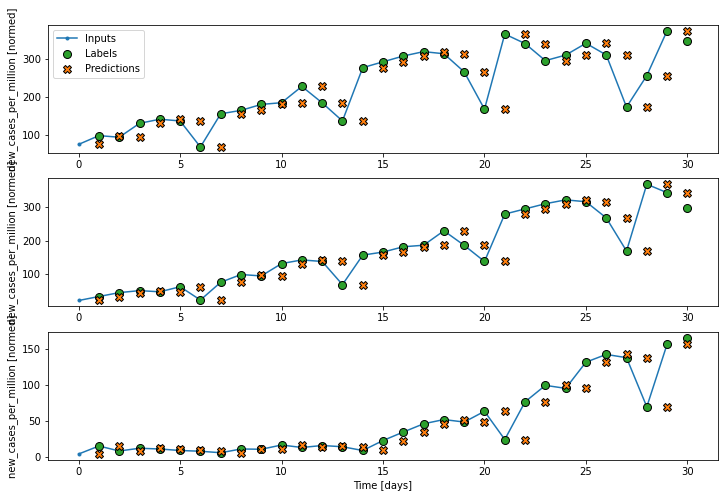

In [13]:
wide_window.plot(baseline, max_subplots=3)

### LSTM predicted vs true signal

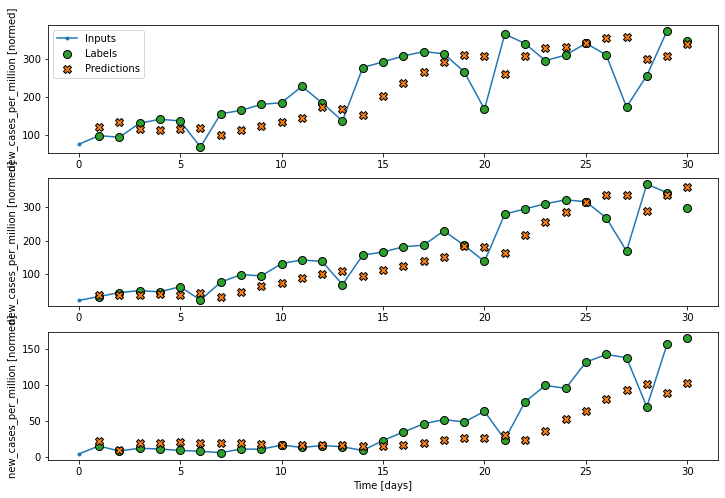

In [14]:
wide_window.plot(lstm_model, max_subplots=3)

### Displaying the error metrics 

In [15]:
performance['Baseline']

[82295.765625, 79.07687377929688, 16538956800.0]

In [16]:
performance['LSTM'] 

[45637.40234375, 80.68805694580078, 23211096064.0]

In [17]:
# Mean Absolute Scaled Error
mase = performance['LSTM'][1] / performance['Baseline'][1]
mase

1.020374897103301